In [4]:
import re
import json
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path
from collections import defaultdict
from scipy.stats import binom

# ============================================================
# 🔧 Helper Functions
# ============================================================

def smooth(values, window_size=200):
    """Centered moving average smoothing."""
    if len(values) < window_size:
        return np.array(values)
    s = pd.Series(values)
    return s.rolling(window=window_size, min_periods=1, center=True).mean().to_numpy()

def tol_interval(arr2d, beta=0.9, alpha=0.05):
    """Nonparametric tolerance interval."""
    n = arr2d.shape[0]
    if n <= 1:
        return arr2d[0], arr2d[0]
    ν = int(binom.ppf(alpha, n, 1 - beta))
    l = int(np.floor(ν / 2))
    u = int(np.ceil(n - ν / 2))
    sorted_ = np.sort(arr2d, axis=0)
    return sorted_[l], sorted_[min(u - 1, n - 1)]

def compute_reavg_curves(runs, common_steps, start_step):
    """Compute re-averaged episode returns after start_step."""
    reavg = []
    for steps, ep_ret, _ in runs:
        mask = steps >= start_step
        if not np.any(mask):
            continue
        ep = ep_ret[mask]
        st = steps[mask]
        roll = np.cumsum(ep) / np.arange(1, len(ep) + 1)
        interp = np.interp(common_steps, st, roll, left=np.nan, right=np.nan)
        reavg.append(interp)
    if not reavg:
        return None
    return np.array(reavg)

def extract_ppo_params(fn):
    """Extract PPO parameters from filename for legend labels."""
    c = re.search(r"clip_param=([\d\.]+)", fn)
    kl = re.search(r"target_kl=([\d\.]+)", fn)
    pi = re.search(r"train_policy_iters=(\d+)", fn)
    vf = re.search(r"train_vf_iters=(\d+)", fn)
    return f"clip={c.group(1) if c else '?'}, kl={kl.group(1) if kl else '?'}, pi={pi.group(1) if pi else '?'}, vf={vf.group(1) if vf else '?'}"

# ============================================================
# 🚀 PPO Analysis Function (Median-Based)
# ============================================================
def analyze_ppo_logs_median(
    log_dir,
    env_name="Unknown Environment",
    start_step=900_000,
    subtitle=None,
    figsize=(18, 14),
    window_size=200,
    save_fig=False,
):
    """
    Analyze PPO training logs and plot median/re-averaged performance with tolerance intervals.

    Parameters
    ----------
    log_dir : str or Path
        Directory containing PPO JSON log files.
    env_name : str
        Environment name (e.g., 'HalfCheetah-v5').
    start_step : int
        Step threshold to start re-averaging.
    subtitle : str
        Optional subtitle for figure.
    figsize : tuple
        Figure size for two-panel plot.
    window_size : int
        Smoothing window for moving average.
    save_fig : bool
        Whether to save the figure as PNG.
    """

    folder = Path(r"\\?\\" + str(Path(log_dir).resolve()))
    files = list(folder.glob("*.json")) + list(folder.glob("*.jso"))
    print(f"Found {len(files)} PPO logs.")
    if not files:
        raise FileNotFoundError("No PPO log files found!")

    # --------------------------
    # Load one training curve
    # --------------------------
    def load_training_curve(p):
        with p.open("r") as f:
            d = json.load(f)
        ev = [e for e in d.get("events", []) if e.get("event") == "train_episode"]
        steps = np.array([e.get("total_steps", 0) for e in ev])
        ep = np.array([e.get("episode_return", np.nan) for e in ev])
        av = np.array([e.get("average_return", np.nan) for e in ev])
        return steps, ep, av

    # --------------------------
    # Group runs by config (ignore seed)
    # --------------------------
    cfg_groups = defaultdict(list)
    for p in files:
        try:
            s, ep, av = load_training_curve(p)
            if len(s) == 0:
                continue
            cfg = re.sub(r"_seed=\d+", "", p.name)
            cfg_groups[cfg].append((s, ep, smooth(av, window_size)))
        except Exception as e:
            print(f"⚠️ {p.name}: {e}")

    print(f"Found {len(cfg_groups)} unique PPO configs.")

    BETA, ALPHA = 0.9, 0.05
    curves, ranking = {}, []

    # --------------------------
    # Compute median, tolerance bands, and re-averages
    # --------------------------
    for cfg, runs in cfg_groups.items():
        if not runs:
            continue
        minlen = min(r[0][-1] for r in runs if len(r[0]) > 0)
        common = np.linspace(0, minlen, 300)

        interp_full = np.array([np.interp(common, s, a) for s, _, a in runs])
        median_full = np.nanmedian(interp_full, 0)
        low_full, up_full = tol_interval(interp_full, BETA, ALPHA)

        reavg_curves = compute_reavg_curves(runs, common, start_step)
        if reavg_curves is None:
            continue
        median_re = np.nanmedian(reavg_curves, 0)
        low_re, up_re = tol_interval(reavg_curves, BETA, ALPHA)

        curves[cfg] = dict(
            steps=common,
            median_full=median_full, low_full=low_full, up_full=up_full,
            median_reavg=median_re, low_reavg=low_re, up_reavg=up_re,
        )

        mask = common >= start_step
        med_perf = np.nanmedian(median_re[mask])
        std_perf = np.nanstd(median_re[mask])
        ranking.append((extract_ppo_params(cfg), med_perf, std_perf, med_perf / (std_perf + 1e-8)))

    # --------------------------
    # Ranking Table
    # --------------------------
    ranking.sort(key=lambda x: x[1], reverse=True)
    df = pd.DataFrame(ranking, columns=["Config", "Median≥900k", "Std≥900k", "Median/Std"])
    print(f"\n📊 PPO Re-Averaged (Median) Performance (≥{start_step:,} steps):\n")
    print(df.to_string(index=False, justify="left", formatters={
        "Median≥900k": "{:,.2f}".format,
        "Std≥900k": "{:,.2f}".format,
        "Median/Std": "{:,.2f}".format
    }))

    # --------------------------
    # Plot
    # --------------------------
    fig, ax = plt.subplots(1, 2, figsize=figsize)
    title_text = f"PPO Median Return – {env_name}"
    if subtitle:
        title_text += f"\n{subtitle}"
    fig.suptitle(title_text, fontsize=16, weight='bold', y=0.98)

    def panel(a, key, low, up, title):
        for i, (cfg, data) in enumerate(curves.items()):
            c = f"C{i % 10}"
            a.plot(data["steps"], data[key], color=c, lw=1.5, alpha=0.85, label=extract_ppo_params(cfg))
            a.fill_between(data["steps"], data[low], data[up], color=c, alpha=0.12)
        a.set_title(title, fontsize=13)
        a.set_xlabel("Cumulative Steps")
        a.set_ylabel("Median Return")
        a.grid(alpha=0.3, linestyle="--")
        a.ticklabel_format(style="plain", axis="x")

    panel(ax[0], "median_full", "low_full", "up_full", "Median Return (Starting from t=0 Steps)")
    panel(ax[1], "median_reavg", "low_reavg", "up_reavg", f"Median Return (Starting from t={start_step/1e6:.1f}M Steps)")

    h, l = ax[0].get_legend_handles_labels()
    fig.legend(h, l, loc="lower center", ncol=3, fontsize=8, frameon=False)
    plt.tight_layout(rect=[0, 0.06, 1, 0.96])

    if save_fig:
        out_path = folder / f"PPO_Median_{env_name.replace(' ', '_')}.png"
        plt.savefig(out_path, dpi=300, bbox_inches="tight")
        print(f"💾 Saved figure to: {out_path}")

    plt.show()
    return df, curves


In [2]:
import re
import json
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path
from collections import defaultdict
from scipy.stats import binom

# ============================================================
# 🔧 Helper Functions
# ============================================================

def smooth(v, w=200):
    """Centered moving average."""
    if len(v) < w:
        return np.array(v)
    s = pd.Series(v)
    return s.rolling(window=w, min_periods=1, center=True).mean().to_numpy()

def tol_interval(arr2d, beta=0.9, alpha=0.05):
    """Distribution-free tolerance interval (α, β)."""
    n = arr2d.shape[0]
    if n <= 1:
        return arr2d[0], arr2d[0]
    ν = int(binom.ppf(alpha, n, 1 - beta))
    l = int(np.floor(ν / 2))
    u = int(np.ceil(n - ν / 2))
    sorted_ = np.sort(arr2d, axis=0)
    return sorted_[l], sorted_[min(u - 1, n - 1)]

def extract_trpo_params(fn):
    """Extract TRPO hyperparameters for legend labels."""
    d = re.search(r"delta=([\d\.]+)", fn)
    c = re.search(r"backtrack_coeff=([\d\.]+)", fn)
    vf = re.search(r"train_vf_iters=(\d+)", fn)
    a = re.search(r"backtrack_alpha=([\d\.]+)", fn)
    return f"δ={d.group(1) if d else '?'}, coeff={c.group(1) if c else '?'}, vf={vf.group(1) if vf else '?'}, α={a.group(1) if a else '?'}"

def compute_reavg_curves(runs, common_steps, start_step):
    """Compute re-averaged episode returns after a given start step."""
    reavg = []
    for steps, ep_ret, _ in runs:
        mask = steps >= start_step
        if not np.any(mask):
            continue
        ep = ep_ret[mask]
        st = steps[mask]
        roll = np.cumsum(ep) / np.arange(1, len(ep) + 1)
        interp = np.interp(common_steps, st, roll, left=np.nan, right=np.nan)
        reavg.append(interp)
    if not reavg:
        return None
    return np.array(reavg)

# ============================================================
# 🚀 TRPO Analysis (Median-based)
# ============================================================
def analyze_trpo_logs_median(
    log_dir,
    env_name="Unknown Environment",
    start_step=900_000,
    subtitle=None,
    figsize=(18, 14),
    window_size=200,
    save_fig=False,
):
    """
    Analyze TRPO training logs (online) using the median across runs,
    and plot tolerance intervals.

    Parameters
    ----------
    log_dir : str or Path
        Directory containing TRPO JSON logs.
    env_name : str
        Environment name (e.g., 'Ant-v5', 'HalfCheetah-v5').
    start_step : int
        Step threshold to start re-averaging (e.g., 900k).
    subtitle : str
        Optional figure subtitle.
    figsize : tuple
        Figure size for dual-panel plot.
    window_size : int
        Smoothing window.
    save_fig : bool
        Whether to save figure as PNG.
    """

    folder = Path(r"\\?\\" + str(Path(log_dir).resolve()))
    files = list(folder.glob("*.json")) + list(folder.glob("*.jso"))
    print(f"Found {len(files)} TRPO logs.")
    if not files:
        raise FileNotFoundError("No TRPO log files found!")

    # --------------------------
    # Load a single training curve
    # --------------------------
    def load_training_curve(p):
        with p.open("r") as f:
            d = json.load(f)
        ev = [e for e in d.get("events", []) if e.get("event") == "train_episode"]
        steps = np.array([e.get("total_steps", 0) for e in ev])
        ep = np.array([e.get("episode_return", np.nan) for e in ev])
        av = np.array([e.get("average_return", np.nan) for e in ev])
        return steps, ep, av

    # --------------------------
    # Group runs by config (ignore seed)
    # --------------------------
    cfg_groups = defaultdict(list)
    for p in files:
        try:
            s, ep, av = load_training_curve(p)
            if len(s) == 0:
                continue
            cfg = re.sub(r"_seed=\d+", "", p.name)
            cfg_groups[cfg].append((s, ep, smooth(av, window_size)))
        except Exception as e:
            print(f"⚠️ {p.name}: {e}")

    print(f"Found {len(cfg_groups)} unique TRPO configs.")

    BETA, ALPHA = 0.9, 0.05
    curves, ranking = {}, []

    # --------------------------
    # Compute median, tolerance bands, and re-averaged curves
    # --------------------------
    for cfg, runs in cfg_groups.items():
        if not runs:
            continue
        minlen = min(r[0][-1] for r in runs if len(r[0]) > 0)
        common = np.linspace(0, minlen, 300)

        interp_full = np.array([np.interp(common, s, a) for s, _, a in runs])
        median_full = np.nanmedian(interp_full, 0)
        low_full, up_full = tol_interval(interp_full, BETA, ALPHA)

        reavg_curves = compute_reavg_curves(runs, common, start_step)
        if reavg_curves is None:
            continue
        median_re = np.nanmedian(reavg_curves, 0)
        low_re, up_re = tol_interval(reavg_curves, BETA, ALPHA)

        curves[cfg] = dict(
            steps=common,
            median_full=median_full, low_full=low_full, up_full=up_full,
            median_reavg=median_re, low_reavg=low_re, up_reavg=up_re,
        )

        mask = common >= start_step
        med_perf = np.nanmedian(median_re[mask])
        std_perf = np.nanstd(median_re[mask])
        ranking.append((extract_trpo_params(cfg), med_perf, std_perf, med_perf / (std_perf + 1e-8)))

    # --------------------------
    # Ranking table
    # --------------------------
    ranking.sort(key=lambda x: x[1], reverse=True)
    df = pd.DataFrame(ranking, columns=["Config", "Median≥900k", "Std≥900k", "Median/Std"])
    print(f"\n📊 TRPO Re-Averaged (Median) Performance (≥{start_step:,} steps):\n")
    print(df.to_string(index=False, justify="left", formatters={
        "Median≥900k": "{:,.2f}".format,
        "Std≥900k": "{:,.2f}".format,
        "Median/Std": "{:,.2f}".format,
    }))

    # --------------------------
    # Plot
    # --------------------------
    fig, ax = plt.subplots(1, 2, figsize=figsize)
    title_text = f"TRPO Median Return – {env_name}"
    if subtitle:
        title_text += f"\n{subtitle}"
    fig.suptitle(title_text, fontsize=16, weight="bold", y=0.98)

    def panel(a, key, low, up, title):
        for i, (cfg, data) in enumerate(curves.items()):
            col = f"C{i % 10}"
            a.plot(data["steps"], data[key], color=col, lw=1.5, alpha=0.85, label=extract_trpo_params(cfg))
            a.fill_between(data["steps"], data[low], data[up], color=col, alpha=0.12)
        a.set_title(title, fontsize=13)
        a.set_xlabel("Cumulative Steps")
        a.set_ylabel("Median Return")
        a.grid(alpha=0.3, linestyle="--")
        a.ticklabel_format(style="plain", axis="x")

    panel(ax[0], "median_full", "low_full", "up_full", "Median Return (Starting from t=0 Steps)")
    panel(ax[1], "median_reavg", "low_reavg", "up_reavg", f"Median Return (Starting from t={start_step/1e6:.1f}M Steps)")

    h, l = ax[0].get_legend_handles_labels()
    fig.legend(h, l, loc="lower center", ncol=3, fontsize=8, frameon=False)
    plt.tight_layout(rect=[0, 0.06, 1, 0.96])

    if save_fig:
        out_path = folder / f"TRPO_Median_{env_name.replace(' ', '_')}.png"
        plt.savefig(out_path, dpi=300, bbox_inches="tight")
        print(f"💾 Saved figure to: {out_path}")

    plt.show()
    return df, curves


Found 48 TRPO logs.
Found 12 unique TRPO configs.

📊 TRPO Re-Averaged (Median) Performance (≥900,000 steps):

Config                           Median≥900k Std≥900k Median/Std
   δ=0.02, coeff=1, vf=10, α=0.5 2,338.10    198.45   11.78     
   δ=0.01, coeff=1, vf=10, α=0.5 2,043.84    118.40   17.26     
   δ=0.02, coeff=1, vf=80, α=0.5 1,433.68    170.07    8.43     
 δ=0.01, coeff=0.8, vf=10, α=0.5 1,159.83    218.15    5.32     
 δ=0.01, coeff=0.8, vf=80, α=0.5 1,157.84     72.08   16.06     
 δ=0.02, coeff=0.8, vf=10, α=0.5 1,085.83    161.69    6.72     
   δ=0.01, coeff=1, vf=80, α=0.5 1,075.01    111.72    9.62     
  δ=0.01, coeff=1, vf=120, α=0.5   986.75     68.51   14.40     
δ=0.02, coeff=0.8, vf=120, α=0.5   982.10    125.04    7.85     
δ=0.01, coeff=0.8, vf=120, α=0.5   887.83     63.74   13.93     
  δ=0.02, coeff=1, vf=120, α=0.5   876.70     75.25   11.65     
 δ=0.02, coeff=0.8, vf=80, α=0.5   821.64    120.42    6.82     


C:\Users\Phong\AppData\Local\Temp\ipykernel_68660\1176543946.py:143: RuntimeWarning: All-NaN slice encountered
  median_re = np.nanmedian(reavg_curves, 0)


💾 Saved figure to: \\?\\C:\Users\Phong\OneDrive\Documents\VSCODEFILE\CMPUT665-PROJECT\trpo_chet\TRPO_Median_HalfCheetah-v5.png


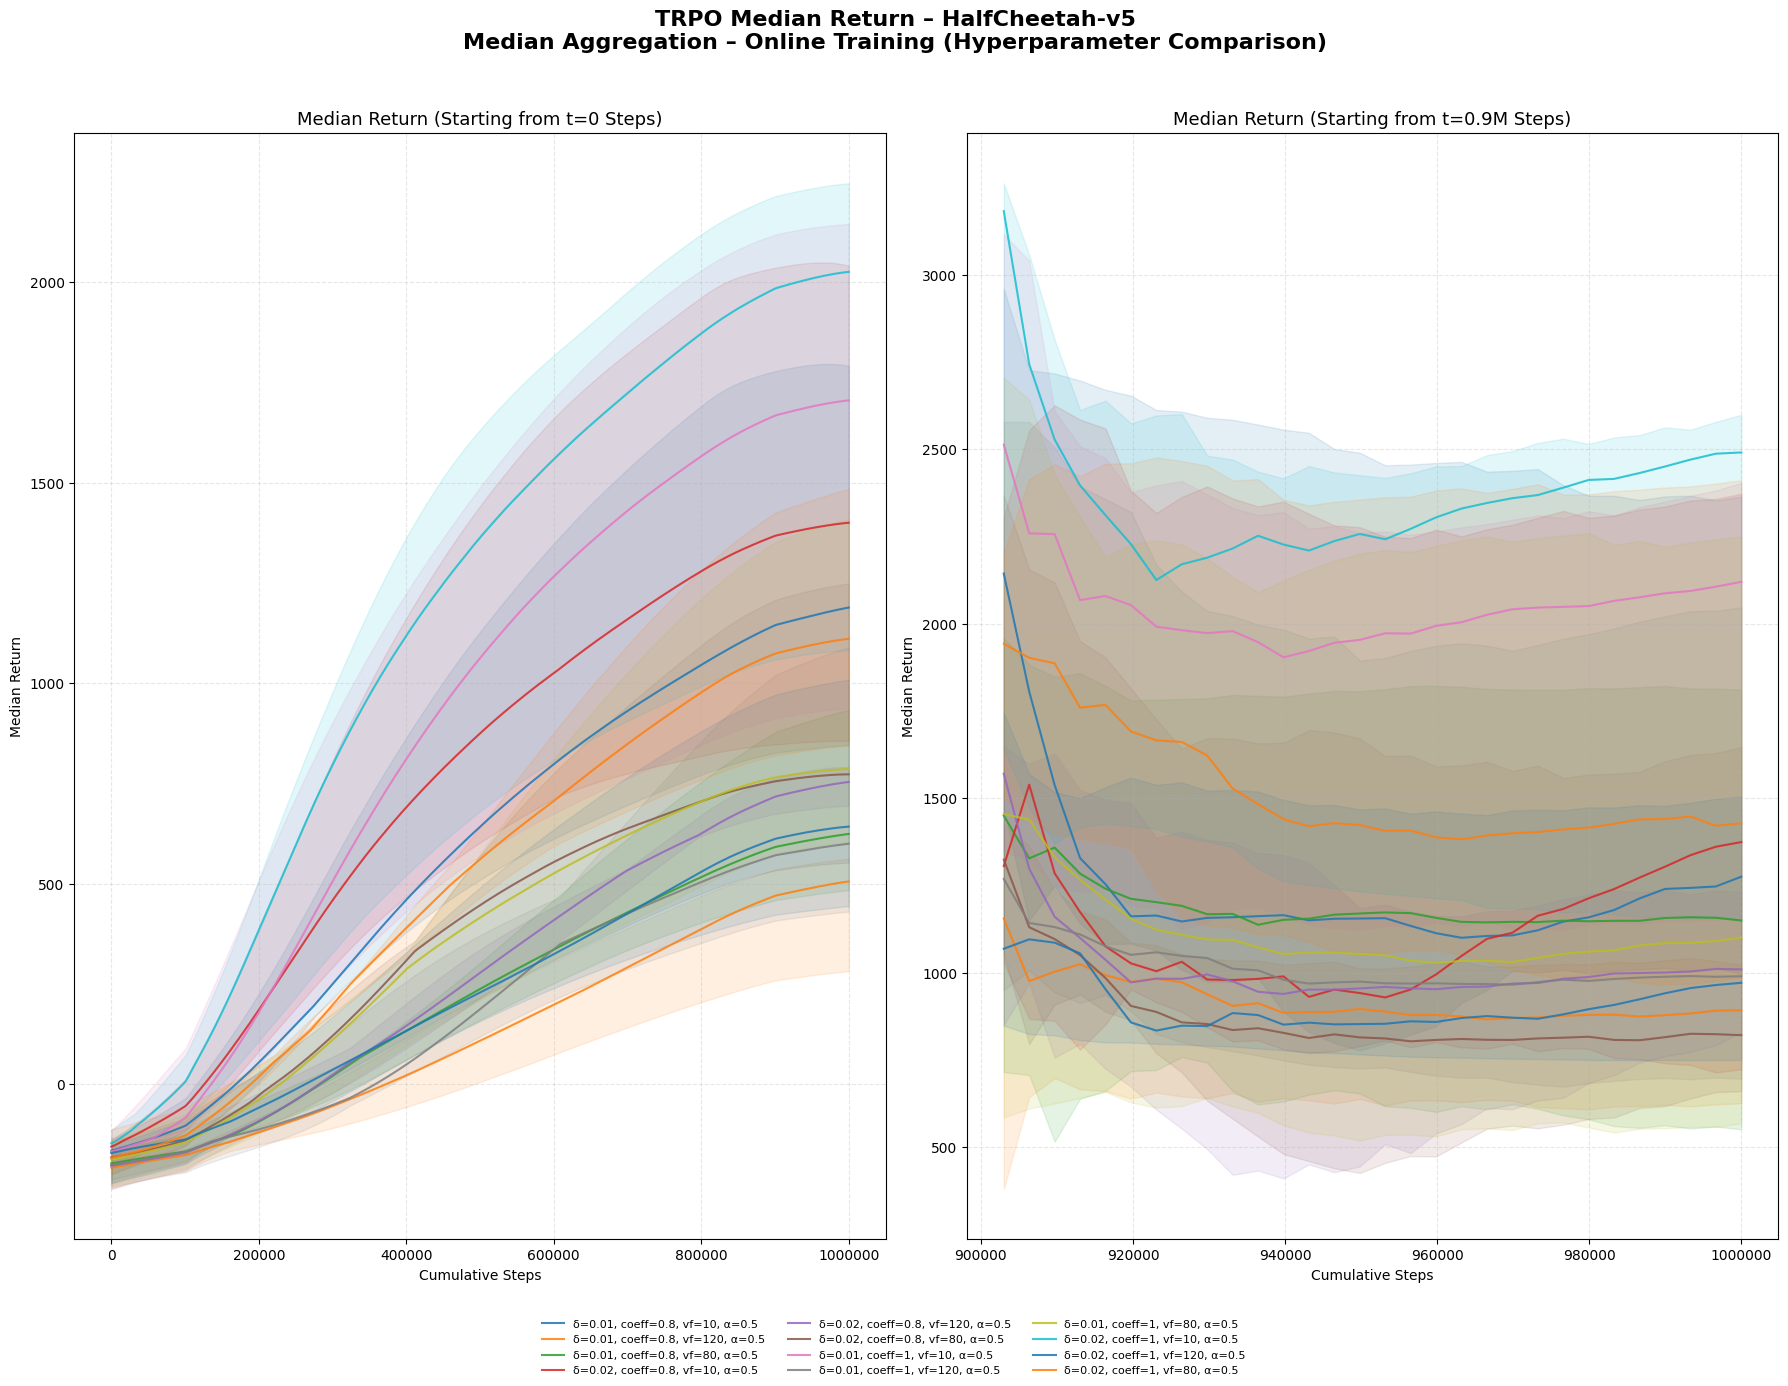

Found 64 PPO logs.
Found 16 unique PPO configs.

📊 PPO Re-Averaged (Median) Performance (≥900,000 steps):

Config                          Median≥900k Std≥900k Median/Std
clip=0.2, kl=0.01, pi=20, vf=10 2,464.08     66.59   37.00     
clip=0.2, kl=0.01, pi=20, vf=20 2,455.94    102.23   24.02     
clip=0.2, kl=0.02, pi=10, vf=20 2,370.74    105.75   22.42     
clip=0.3, kl=0.02, pi=20, vf=20 2,153.19     91.21   23.61     
clip=0.3, kl=0.02, pi=10, vf=10 2,099.76    219.01    9.59     
clip=0.3, kl=0.01, pi=10, vf=10 2,025.16    146.06   13.87     
clip=0.2, kl=0.02, pi=20, vf=10 2,001.49    131.85   15.18     
clip=0.2, kl=0.01, pi=10, vf=20 1,923.38    134.61   14.29     
clip=0.3, kl=0.02, pi=10, vf=20 1,879.46     46.11   40.76     
clip=0.2, kl=0.02, pi=10, vf=10 1,868.42     71.39   26.17     
clip=0.3, kl=0.01, pi=20, vf=10 1,811.50     74.18   24.42     
clip=0.2, kl=0.02, pi=20, vf=20 1,802.37    122.11   14.76     
clip=0.3, kl=0.02, pi=20, vf=10 1,736.09    299.13    5.80   

C:\Users\Phong\AppData\Local\Temp\ipykernel_68660\644327345.py:142: RuntimeWarning: All-NaN slice encountered
  median_re = np.nanmedian(reavg_curves, 0)


💾 Saved figure to: \\?\\C:\Users\Phong\OneDrive\Documents\VSCODEFILE\CMPUT665-PROJECT\ppo_chet\PPO_Median_HalfCheetah-v5.png


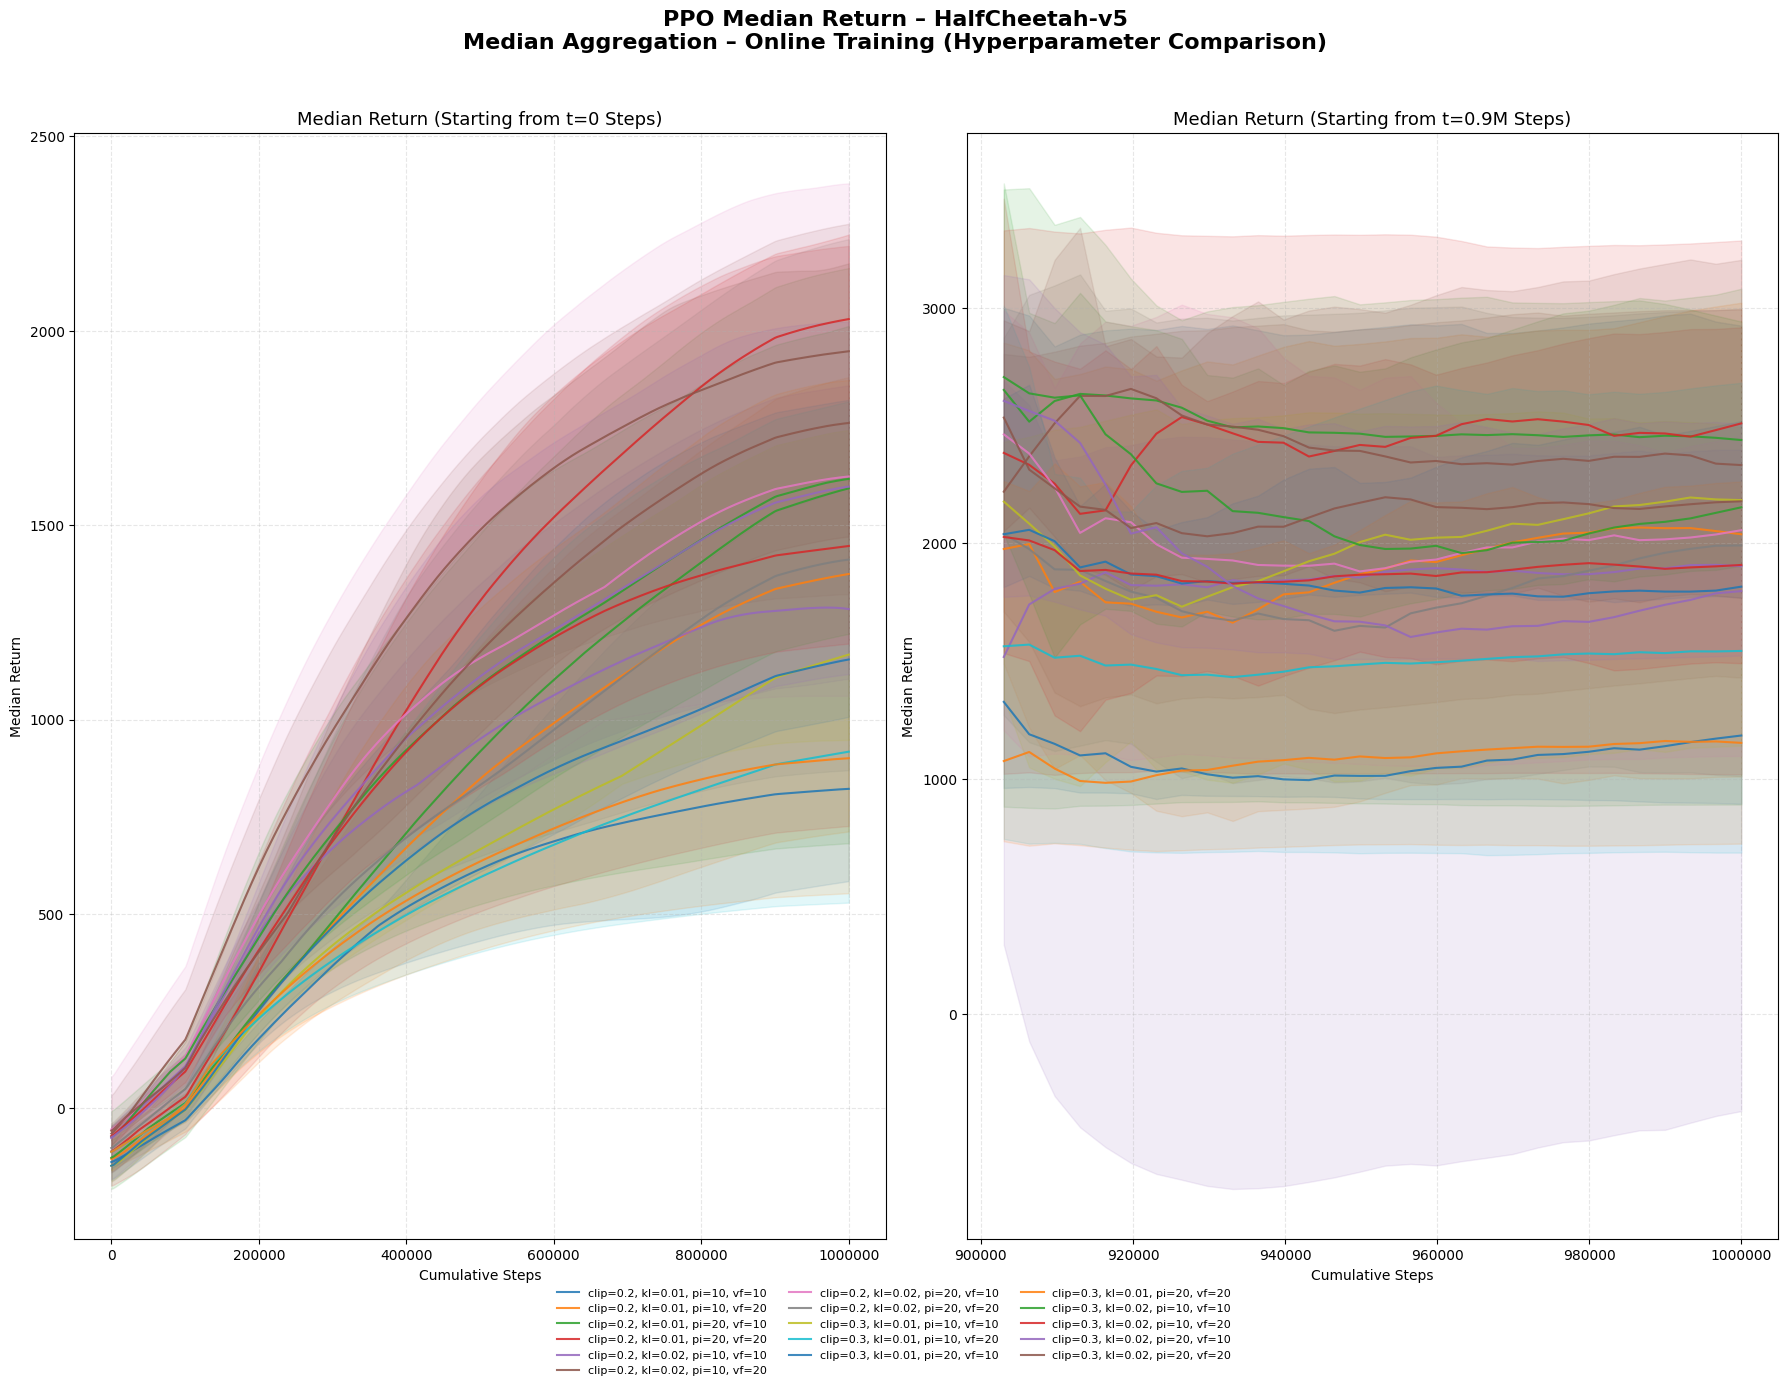

Found 48 TRPO logs.
Found 12 unique TRPO configs.

📊 TRPO Re-Averaged (Median) Performance (≥900,000 steps):

Config                           Median≥900k Std≥900k Median/Std
   δ=0.01, coeff=1, vf=10, α=0.5 409.73      22.01    18.62     
 δ=0.02, coeff=0.8, vf=10, α=0.5 390.36      22.24    17.55     
   δ=0.02, coeff=1, vf=10, α=0.5 354.35      25.87    13.70     
 δ=0.01, coeff=0.8, vf=10, α=0.5 309.78      21.56    14.37     
 δ=0.01, coeff=0.8, vf=80, α=0.5 155.03       4.48    34.60     
   δ=0.02, coeff=1, vf=80, α=0.5 136.46       4.39    31.06     
   δ=0.01, coeff=1, vf=80, α=0.5 135.15       5.66    23.89     
 δ=0.02, coeff=0.8, vf=80, α=0.5 130.01       4.93    26.37     
  δ=0.01, coeff=1, vf=120, α=0.5 113.06       4.22    26.77     
δ=0.01, coeff=0.8, vf=120, α=0.5 106.82       3.86    27.68     
  δ=0.02, coeff=1, vf=120, α=0.5  84.83       3.76    22.58     
δ=0.02, coeff=0.8, vf=120, α=0.5  80.94       4.47    18.10     


C:\Users\Phong\AppData\Local\Temp\ipykernel_68660\1176543946.py:143: RuntimeWarning: All-NaN slice encountered
  median_re = np.nanmedian(reavg_curves, 0)


💾 Saved figure to: \\?\\C:\Users\Phong\OneDrive\Documents\VSCODEFILE\CMPUT665-PROJECT\trpo_ant\TRPO_Median_Ant-v5.png


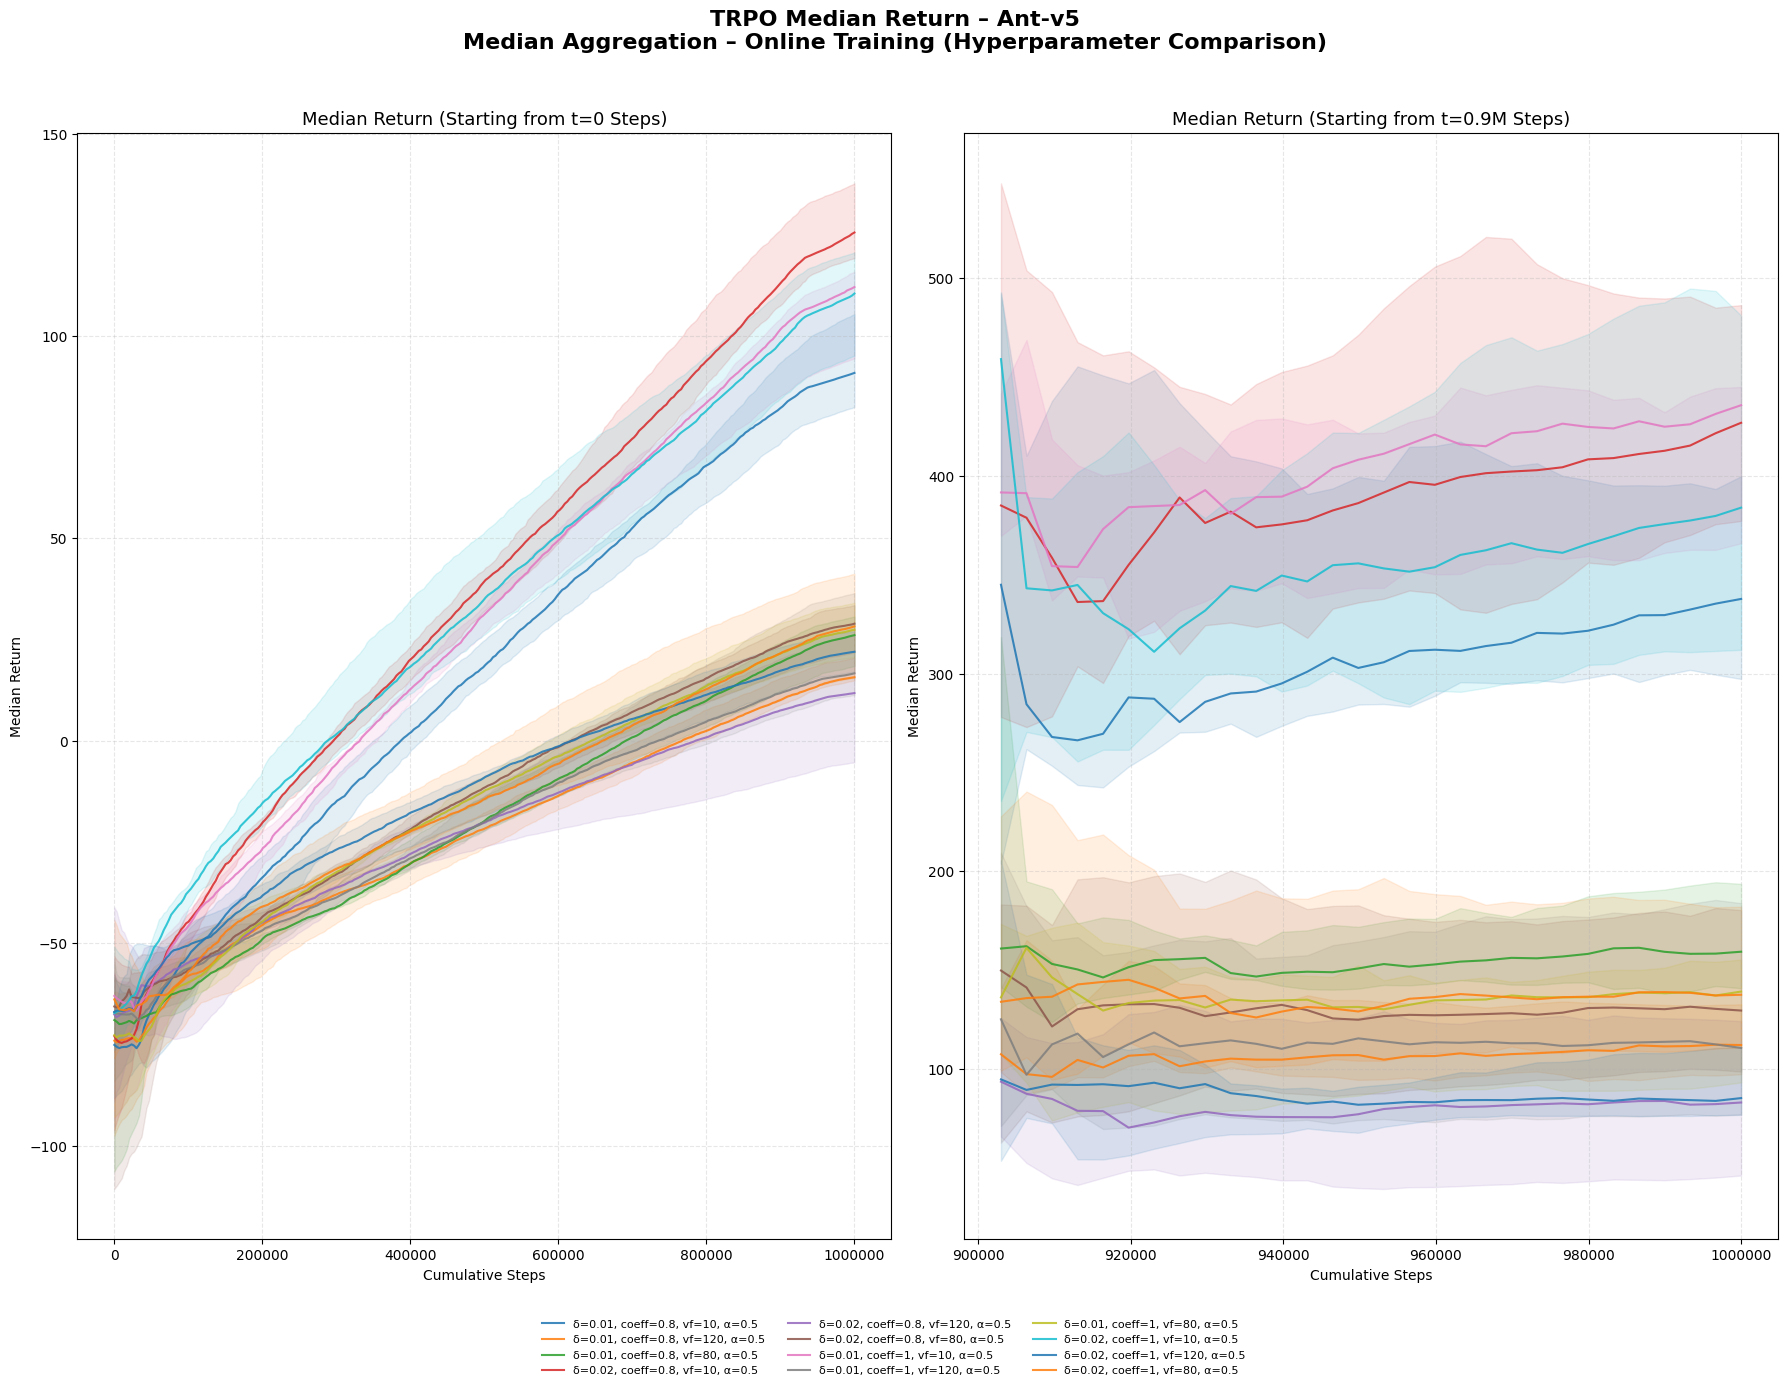

Found 64 PPO logs.
Found 16 unique PPO configs.

📊 PPO Re-Averaged (Median) Performance (≥900,000 steps):

Config                          Median≥900k Std≥900k Median/Std
clip=0.2, kl=0.02, pi=20, vf=10 873.10      29.71    29.38     
clip=0.2, kl=0.02, pi=10, vf=10 765.58      57.11    13.40     
clip=0.2, kl=0.02, pi=10, vf=20 764.31      26.35    29.00     
clip=0.3, kl=0.01, pi=10, vf=10 733.58      24.60    29.83     
clip=0.3, kl=0.01, pi=20, vf=10 733.58      24.60    29.83     
clip=0.3, kl=0.02, pi=10, vf=20 714.34      16.37    43.65     
clip=0.2, kl=0.02, pi=20, vf=20 703.34      27.75    25.34     
clip=0.3, kl=0.02, pi=10, vf=10 698.90      59.83    11.68     
clip=0.2, kl=0.01, pi=10, vf=10 694.97      19.74    35.21     
clip=0.2, kl=0.01, pi=10, vf=20 663.68      14.35    46.26     
clip=0.2, kl=0.01, pi=20, vf=10 649.17      27.92    23.25     
clip=0.3, kl=0.02, pi=20, vf=10 621.06      28.16    22.05     
clip=0.3, kl=0.02, pi=20, vf=20 586.65      30.72    19.10   

C:\Users\Phong\AppData\Local\Temp\ipykernel_68660\644327345.py:142: RuntimeWarning: All-NaN slice encountered
  median_re = np.nanmedian(reavg_curves, 0)


💾 Saved figure to: \\?\\C:\Users\Phong\OneDrive\Documents\VSCODEFILE\CMPUT665-PROJECT\ppo_ant\PPO_Median_Ant-v5.png


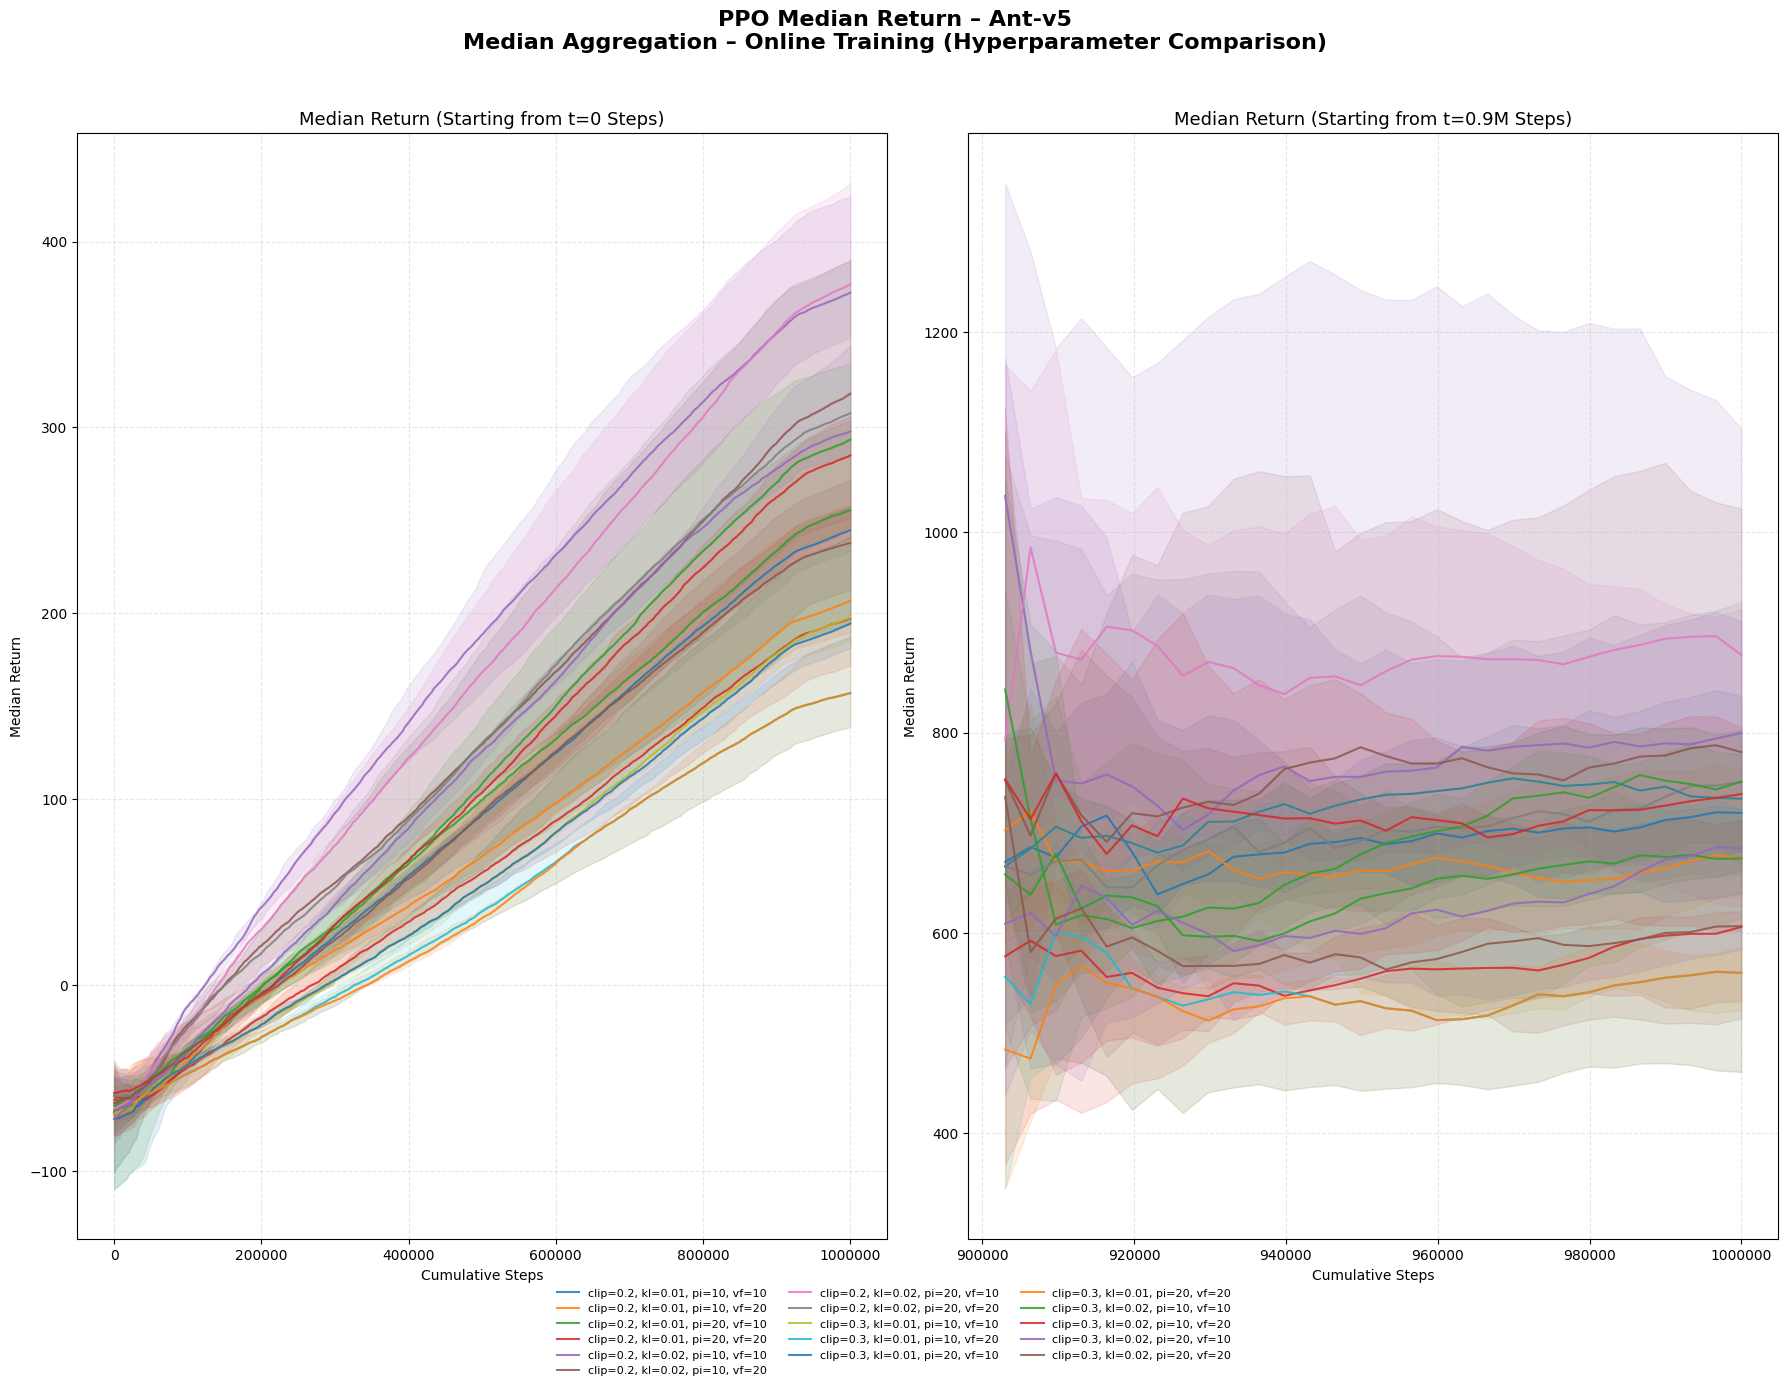

In [5]:
# ============================================================
# 🧩 ONLINE MEDIAN ANALYSIS — PPO + TRPO
# ============================================================

# --- HalfCheetah-v5 ---
df_trpo_med_chet, curves_trpo_med_chet = analyze_trpo_logs_median(
    log_dir=r"C:/Users/Phong/OneDrive/Documents/VSCODEFILE/CMPUT665-PROJECT/trpo_chet",
    env_name="HalfCheetah-v5",
    subtitle="Median Aggregation – Online Training (Hyperparameter Comparison)",
    save_fig=True,
)

df_ppo_med_chet, curves_ppo_med_chet = analyze_ppo_logs_median(
    log_dir=r"C:/Users/Phong/OneDrive/Documents/VSCODEFILE/CMPUT665-PROJECT/ppo_chet",
    env_name="HalfCheetah-v5",
    subtitle="Median Aggregation – Online Training (Hyperparameter Comparison)",
    save_fig=True,
)


# --- Ant-v5 ---
df_trpo_med_ant, curves_trpo_med_ant = analyze_trpo_logs_median(
    log_dir=r"C:/Users/Phong/OneDrive/Documents/VSCODEFILE/CMPUT665-PROJECT/trpo_ant",
    env_name="Ant-v5",
    subtitle="Median Aggregation – Online Training (Hyperparameter Comparison)",
    save_fig=True,
)

df_ppo_med_ant, curves_ppo_med_ant = analyze_ppo_logs_median(
    log_dir=r"C:/Users/Phong/OneDrive/Documents/VSCODEFILE/CMPUT665-PROJECT/ppo_ant",
    env_name="Ant-v5",
    subtitle="Median Aggregation – Online Training (Hyperparameter Comparison)",
    save_fig=True,
)
